In [1]:
!pip3 install pandas


You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.metrics import mean_squared_error
from math import sqrt

## Reading the collections of database

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    #if no_id:
    #    del df['_id']

    return df


In [4]:
recommendation_tracks = read_mongo(db="social_tracks_api", collection="recommendationtracks")
recommendation_tracks = recommendation_tracks.rename(columns = {"id" : "spotify_track_id", "_id" : "recommendation_tracks_ids" })
recommendation_tracks.drop(["__v", "album", "artists","created_at","explicit","updated_at","uri"],axis=1, inplace=True)
recommendation_tracks.head()

,recommendation_tracks_ids,spotify_track_id,name,prediction
0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.805156
1,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.803134
2,5cd5d9bbb267216152b925af,3n3Ppam7vgaVa1iaRUc9Lp,Mr. Brightside,1.722304
3,5cd5d9bbb267216152b925b0,2DlHlPMa4M17kufBvI2lEN,Chop Suey!,1.715553
4,5cd5d9bbb267216152b925b1,0MKGH8UMfCnq5w7nG06oM5,Come As You Are,1.703052


In [5]:
ratings = read_mongo(db="social_tracks_api", collection="ratings")
ratings.drop(["__v", "created_at","updated_at", "_id"], axis=1, inplace=True)
ratings =  ratings.rename(columns =  {"user" :  "user_id"})
ratings.head()

,spotify_track_id,user_id,value
0,5qqabIl2vWzo9ApSC317sa,5ccb4a282b22bd25daba91fb,5
1,0gEyKnHvgkrkBM6fbeHdwK,5ccb4a282b22bd25daba91fb,5
2,1f3yAtsJtY87CTmM8RLnxf,5ccb4a282b22bd25daba91fb,2
3,31AOj9sFz2gM0O3hMARRBx,5ccb4a282b22bd25daba91fb,4
4,0MKGH8UMfCnq5w7nG06oM5,5ccb4a282b22bd25daba91fb,2


In [6]:
recommendations = read_mongo(db="social_tracks_api", collection="recommendations")
recommendations = recommendations.rename(columns = {"recommendation_tracks" : "recommendation_tracks_ids"})
recommendations.head()

,__v,_id,created_at,generating_recommendation,group,influence_factors,recommendation_tracks_ids,updated_at
0,1,5cd5d89eb267216152b925ac,2019-05-10 20:01:34.722,False,5cd5d896b267216152b925ab,{'final': {'5cb5312801d15c5ce3ca5d6b': 1.41568...,"[5cd5d9bab267216152b925ad, 5cd5d9bbb267216152b...",2019-05-10 20:06:21.866
1,1,5cd5ddafb267216152b925c3,2019-05-10 20:23:11.895,False,5cd5dd71b267216152b925c2,{'final': {'5cc64b69a01149637826f89d': 1.34834...,"[5cd5de7ab267216152b925c5, 5cd5de7ab267216152b...",2019-05-10 20:26:37.332
2,1,5cd5ddb9b267216152b925c4,2019-05-10 20:23:21.249,False,5cd5dd3db267216152b925c1,{'final': {'5cb8bd1dcb7aca572d99558e': 1.46851...,"[5cd5df0cb267216152b925d9, 5cd5df0db267216152b...",2019-05-10 20:29:03.778
3,1,5cd5df83b267216152b925ee,2019-05-10 20:30:59.949,False,5cd5df73b267216152b925ed,{'final': {'5ccb4a282b22bd25daba91fb': 1.41528...,"[5cd5e0c7b267216152b92607, 5cd5e0c7b267216152b...",2019-05-10 20:36:26.218
4,1,5cd5e658b267216152b9261c,2019-05-10 21:00:08.440,False,5cd5e650b267216152b9261b,{'final': {'5cb8bd1dcb7aca572d99558e': 1.37947...,"[5cd5e729b267216152b9261d, 5cd5e72ab267216152b...",2019-05-10 21:03:40.504


## Extracting the influence factors

In [7]:
def influence_factors_tables(dataframe):
    dataframe = pd.concat([dataframe['influence_factors'].apply(pd.Series)], axis=0)
    count_groups_df =  dataframe.shape[0]
    for group in range(count_groups_df):
        sub_df = dataframe.iloc[group]
        sub_df= pd.concat([sub_df.apply(pd.Series)], axis=1)
        sub_df.drop('friendly', axis=0)
        sub_df = sub_df.reindex(["expert", "leadership", "similarities","final" ])

        factors_tables =  sub_df.transpose()
        factors_tables.reset_index(level=0, inplace=True)
        factors_tables = factors_tables.rename(columns = {"index" : "user_id"})
       # factors_tables['user'] = factors_tables.groupby(['user_id']).ngroup()
       # cols = factors_tables.columns.tolist()
       # cols = cols[-1:] + cols[:-1]
       # factors_tables = factors_tables[cols]


        print("GROUP {} ->>> Influence factors<<<-: \n {}" .format(group+1, factors_tables))
    
    

In [8]:
x = influence_factors_tables(recommendations)

GROUP 1 ->>> Influence factors<<<-: 
                     user_id    expert  leadership  similarities     final
0  5cb5312801d15c5ce3ca5d6b  0.818488    0.261905      0.166667  1.415687
1  5cc1f3a05baaa56ae50ad69d  0.190978    0.416667      0.083333  1.230326
2  5cc662aa6acc0863cb551746  0.364472    0.293651      0.041667  1.233263
3  5cd323a535da1d02b66160b2  0.626061    0.361111      0.041667  1.342946
GROUP 2 ->>> Influence factors<<<-: 
                     user_id    expert  leadership  similarities     final
0  5cc64b69a01149637826f89d  0.433912    0.111111           0.5  1.348341
1  5ccb4a282b22bd25daba91fb  0.566088    0.555556           0.5  1.540548
GROUP 3 ->>> Influence factors<<<-: 
                     user_id    expert  leadership  similarities     final
0  5cb8bd1dcb7aca572d99558e  0.603749    0.279266      0.522544  1.468520
1  5cc64b69a01149637826f89d  0.401691    0.275851      0.195370  1.290971
2  5ccb4a282b22bd25daba91fb  0.494561    0.444884      0.477174  1.47220

## Ordering the user's ratings by the group into data frame

In [9]:
groups = read_mongo(db="social_tracks_api", collection="groups")
groups.drop(["created_at","__v","owner", "updated_at", "name"], axis=1, inplace=True)
groups

,_id,users
0,5cd5d896b267216152b925ab,"[5cc1f3a05baaa56ae50ad69d, 5cb5312801d15c5ce3c..."
1,5cd5dd3db267216152b925c1,"[5ccb4a282b22bd25daba91fb, 5cb8bd1dcb7aca572d9..."
2,5cd5dd71b267216152b925c2,"[5ccb4a282b22bd25daba91fb, 5cc64b69a0114963782..."
3,5cd5df73b267216152b925ed,"[5cc662aa6acc0863cb551746, 5cc64b69a0114963782..."
4,5cd5e650b267216152b9261b,"[5cb5312801d15c5ce3ca5d6b, 5cb8bd1dcb7aca572d9..."
5,5cd5e76eb267216152b92631,"[5cc662aa6acc0863cb551746, 5ccb4a282b22bd25dab..."
6,5cd5e839b267216152b92632,"[5cb5312801d15c5ce3ca5d6b, 5cb8bd1dcb7aca572d9..."
7,5cd5ee20b267216152b92663,"[5cc1f3a05baaa56ae50ad69d, 5cb8bd1dcb7aca572d9..."
8,5cd9d5349c375a106d735438,"[5cb5312801d15c5ce3ca5d6b, 5cd1c17e3b62245f3e3..."
9,5cdaff236d552b38343399dc,"[5cc662aa6acc0863cb551746, 5cb46ca701d15c5ce3c..."


In [10]:
id_groups = groups.iloc[:,0]
id_groups

0    5cd5d896b267216152b925ab
1    5cd5dd3db267216152b925c1
2    5cd5dd71b267216152b925c2
3    5cd5df73b267216152b925ed
4    5cd5e650b267216152b9261b
5    5cd5e76eb267216152b92631
6    5cd5e839b267216152b92632
7    5cd5ee20b267216152b92663
8    5cd9d5349c375a106d735438
9    5cdaff236d552b38343399dc
Name: _id, dtype: object

In [11]:
id_users =  read_mongo(db="social_tracks_api", collection="users")
id_users =  id_users.iloc[:, 1]
id_users

0     5cb46ca701d15c5ce3ca5d6a
1     5cb5312801d15c5ce3ca5d6b
2     5cb8bd1dcb7aca572d99558e
3     5cc051556b12064b2f9ee11c
4     5cc1f3a05baaa56ae50ad69d
5     5cc64b69a01149637826f89d
6     5cc662756acc0863cb551745
7     5cc662aa6acc0863cb551746
8     5ccb4a282b22bd25daba91fb
9     5cd0463a02c404492300cb1b
10    5cd1c17e3b62245f3e3b2ff8
11    5cd323a535da1d02b66160b2
12    5ce157137d9f096ce0e406f0
Name: _id, dtype: object

In [12]:
users_groups  = groups.copy()
extract_users =  pd.concat([users_groups["users"].apply(pd.Series)], axis=0)
extract_users =  extract_users.transpose()


In [13]:
extract_u =  pd.melt(extract_users)
extract_u = extract_u.rename(columns = {"variable" : "group", "value" : "user_id"})
final_users_group = extract_u[extract_u['user_id'].notnull()]
final_users_group

,group,user_id
0,0,5cc1f3a05baaa56ae50ad69d
1,0,5cb5312801d15c5ce3ca5d6b
2,0,5cc662aa6acc0863cb551746
3,0,5cd323a535da1d02b66160b2
10,1,5ccb4a282b22bd25daba91fb
11,1,5cb8bd1dcb7aca572d99558e
12,1,5cc64b69a01149637826f89d
20,2,5ccb4a282b22bd25daba91fb
21,2,5cc64b69a01149637826f89d
30,3,5cc662aa6acc0863cb551746


In [14]:
df_merge_users_ratings = pd.merge(ratings, final_users_group, on=["user_id"])
df_merge_users_ratings

,spotify_track_id,user_id,value,group
0,5qqabIl2vWzo9ApSC317sa,5ccb4a282b22bd25daba91fb,5,1
1,5qqabIl2vWzo9ApSC317sa,5ccb4a282b22bd25daba91fb,5,2
2,5qqabIl2vWzo9ApSC317sa,5ccb4a282b22bd25daba91fb,5,3
3,5qqabIl2vWzo9ApSC317sa,5ccb4a282b22bd25daba91fb,5,5
4,5qqabIl2vWzo9ApSC317sa,5ccb4a282b22bd25daba91fb,5,9
5,0gEyKnHvgkrkBM6fbeHdwK,5ccb4a282b22bd25daba91fb,5,1
6,0gEyKnHvgkrkBM6fbeHdwK,5ccb4a282b22bd25daba91fb,5,2
7,0gEyKnHvgkrkBM6fbeHdwK,5ccb4a282b22bd25daba91fb,5,3
8,0gEyKnHvgkrkBM6fbeHdwK,5ccb4a282b22bd25daba91fb,5,5
9,0gEyKnHvgkrkBM6fbeHdwK,5ccb4a282b22bd25daba91fb,5,9


In [15]:
tracks_groups = recommendations.copy()
tracks_groups.drop(["__v", "_id", "created_at", "generating_recommendation", "influence_factors", "updated_at"], axis=1, inplace=True)
tracks_groups
#tracks_groups.

,group,recommendation_tracks_ids
0,5cd5d896b267216152b925ab,"[5cd5d9bab267216152b925ad, 5cd5d9bbb267216152b..."
1,5cd5dd71b267216152b925c2,"[5cd5de7ab267216152b925c5, 5cd5de7ab267216152b..."
2,5cd5dd3db267216152b925c1,"[5cd5df0cb267216152b925d9, 5cd5df0db267216152b..."
3,5cd5df73b267216152b925ed,"[5cd5e0c7b267216152b92607, 5cd5e0c7b267216152b..."
4,5cd5e650b267216152b9261b,"[5cd5e729b267216152b9261d, 5cd5e72ab267216152b..."
5,5cd5e839b267216152b92632,"[5cd5e8e4b267216152b92634, 5cd5e8e4b267216152b..."
6,5cd5e76eb267216152b92631,"[5cd5eafab267216152b9264f, 5cd5eafab267216152b..."
7,5cd5ee20b267216152b92663,"[5cd5ef74b267216152b92665, 5cd5ef75b267216152b..."
8,5cd9d5349c375a106d735438,"[5cdb06ff6d552b38343399df, 5cdb06ff6d552b38343..."
9,5cdaff236d552b38343399dc,"[5cdb0c016d552b38343399f4, 5cdb0c016d552b38343..."


## Ordering the recommender tracks by the group into data frame

In [16]:
extract_tracks =  pd.concat([tracks_groups["recommendation_tracks_ids"].apply(pd.Series)], axis=0)
extract_tracks = extract_tracks.transpose()

In [17]:
extract =  pd.melt(extract_tracks)
extract =  extract.rename(columns = {"variable" : "group", "value" : "recommendation_tracks_ids"})
extract

,group,recommendation_tracks_ids
0,0,5cd5d9bab267216152b925ad
1,0,5cd5d9bbb267216152b925ae
2,0,5cd5d9bbb267216152b925af
3,0,5cd5d9bbb267216152b925b0
4,0,5cd5d9bbb267216152b925b1
5,0,5cd5d9bbb267216152b925b2
6,0,5cd5d9bbb267216152b925b3
7,0,5cd5d9bcb267216152b925b4
8,0,5cd5d9bcb267216152b925b5
9,0,5cd5d9bcb267216152b925b6


In [18]:
type(extract)

pandas.core.frame.DataFrame

In [19]:
df_merger = pd.merge(extract, recommendation_tracks, on="recommendation_tracks_ids")
df_merger

,group,recommendation_tracks_ids,spotify_track_id,name,prediction
0,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.805156
1,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.803134
2,0,5cd5d9bbb267216152b925af,3n3Ppam7vgaVa1iaRUc9Lp,Mr. Brightside,1.722304
3,0,5cd5d9bbb267216152b925b0,2DlHlPMa4M17kufBvI2lEN,Chop Suey!,1.715553
4,0,5cd5d9bbb267216152b925b1,0MKGH8UMfCnq5w7nG06oM5,Come As You Are,1.703052
5,0,5cd5d9bbb267216152b925b2,5VGlqQANWDKJFl0MBG3sg2,Use Somebody,1.700204
6,0,5cd5d9bbb267216152b925b3,75JFxkI2RXiU7L9VXzMkle,The Scientist,1.659663
7,0,5cd5d9bcb267216152b925b4,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,1.650564
8,0,5cd5d9bcb267216152b925b5,0snQkGI5qnAmohLE7jTsTn,Toxicity,1.647925
9,0,5cd5d9bcb267216152b925b6,4dVbhS6OiYvFikshyaQaCN,My Hero,1.635268


## Dataframe with information about the prediction of the tracks and ratings of them by each user in each group

In [20]:
total_merge =  pd.merge(df_merger, df_merge_users_ratings, on=["spotify_track_id", "group"])
total_merge.style

,group,recommendation_tracks_ids,spotify_track_id,name,prediction,user_id,value
0,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.80516,5cc662aa6acc0863cb551746,5
1,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.80516,5cc1f3a05baaa56ae50ad69d,1
2,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.80516,5cb5312801d15c5ce3ca5d6b,2
3,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.80516,5cd323a535da1d02b66160b2,5
4,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.80313,5cc662aa6acc0863cb551746,5
5,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.80313,5cc1f3a05baaa56ae50ad69d,5
6,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.80313,5cb5312801d15c5ce3ca5d6b,4
7,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.80313,5cd323a535da1d02b66160b2,5
8,0,5cd5d9bbb267216152b925af,3n3Ppam7vgaVa1iaRUc9Lp,Mr. Brightside,1.7223,5cc662aa6acc0863cb551746,4
9,0,5cd5d9bbb267216152b925af,3n3Ppam7vgaVa1iaRUc9Lp,Mr. Brightside,1.7223,5cc1f3a05baaa56ae50ad69d,1


## Function to normalize predictions


In [22]:
copy_total_merge = total_merge.copy()


In [23]:
max_predic =  copy_total_merge.prediction.max()
max_predic = max_predic.round(4)

#copy_total_merge["R_sytem"]  = 0
rate = []
for x in copy_total_merge.prediction:
    r = abs((x/max_predic)*4)+1
    r =  r.round()
    rate.append(r)

copy_total_merge["R_system"] = pd.Series(rate)

In [24]:
#copy_total_merge.drop(["norm_predic", "normalize"], axis=1, inplace=True)
copy_total_merge.style

,group,recommendation_tracks_ids,spotify_track_id,name,prediction,user_id,value,R_system
0,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.80516,5cc662aa6acc0863cb551746,5,4
1,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.80516,5cc1f3a05baaa56ae50ad69d,1,4
2,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.80516,5cb5312801d15c5ce3ca5d6b,2,4
3,0,5cd5d9bab267216152b925ad,5UWwZ5lm5PKu6eKsHAGxOk,Everlong,1.80516,5cd323a535da1d02b66160b2,5,4
4,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.80313,5cc662aa6acc0863cb551746,5,4
5,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.80313,5cc1f3a05baaa56ae50ad69d,5,4
6,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.80313,5cb5312801d15c5ce3ca5d6b,4,4
7,0,5cd5d9bbb267216152b925ae,1f3yAtsJtY87CTmM8RLnxf,Smells Like Teen Spirit,1.80313,5cd323a535da1d02b66160b2,5,4
8,0,5cd5d9bbb267216152b925af,3n3Ppam7vgaVa1iaRUc9Lp,Mr. Brightside,1.7223,5cc662aa6acc0863cb551746,4,4
9,0,5cd5d9bbb267216152b925af,3n3Ppam7vgaVa1iaRUc9Lp,Mr. Brightside,1.7223,5cc1f3a05baaa56ae50ad69d,1,4


## Function to calculate the tracks' average ratings  in each group

In [53]:
x = copy_total_merge.groupby(['recommendation_tracks_ids', "name"]).mean()
x = x.rename(columns = {"value" : "R_av", "prediction" : "RG"})

new_order = [0, 1,3,2]
x = x[x.columns[new_order]]

x.style

,,group,RG,R_system,R_av
recommendation_tracks_ids,name,,,,
5cd5d9bab267216152b925ad,Everlong,0,1.80516,4,3.25
5cd5d9bbb267216152b925ae,Smells Like Teen Spirit,0,1.80313,4,4.75
5cd5d9bbb267216152b925af,Mr. Brightside,0,1.7223,4,3
5cd5d9bbb267216152b925b0,Chop Suey!,0,1.71555,4,4.75
5cd5d9bbb267216152b925b1,Come As You Are,0,1.70305,4,4.25
5cd5d9bbb267216152b925b2,Use Somebody,0,1.7002,4,3
5cd5d9bbb267216152b925b3,The Scientist,0,1.65966,4,4.25
5cd5d9bcb267216152b925b4,Wonderwall - Remastered,0,1.65056,4,4.25
5cd5d9bcb267216152b925b5,Toxicity,0,1.64793,4,4.25


## Distribution of prediction given by GRS and by the groups

In [33]:
from matplotlib import pyplot as plt



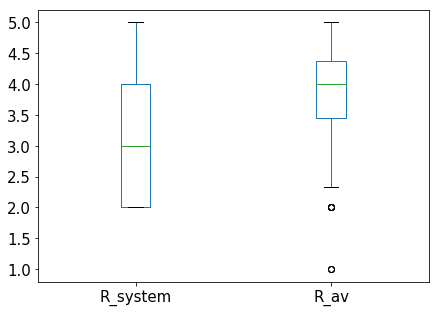

In [49]:
x[['R_system','R_av']].boxplot(grid=False, fontsize=15, figsize=(7,5))

## RMSE

In [51]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


rms_1 = sqrt(mean_squared_error(x.R_av, x.R_system))

#rms = mean_squared_error(x.value, x.norm_predic)
print (rms_1)



1.4517350663086142


## Filter the recommended tracks for a group

In [26]:
y = x.loc[x['group'] == 4]

y[["group"]] =  y[["group"]].replace([4],[5])

y.style


/home/ubuntu/data-analise-social-tracks/analise/lib/python3.5/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,,group,RG,R_system,R_av
recommendation_tracks_ids,name,,,,
5cd5e729b267216152b9261d,Smells Like Teen Spirit,5,1.59817,4,4.66667
5cd5e72ab267216152b9261e,Come As You Are,5,1.56815,4,4.33333
5cd5e72ab267216152b9261f,Wonderwall - Remastered,5,1.54156,4,3.33333
5cd5e72ab267216152b92620,Losing My Religion,5,1.50466,4,4.33333
5cd5e72ab267216152b92621,Linger,5,1.43899,4,3.66667
5cd5e72ab267216152b92622,Creep,5,1.43369,4,4.33333
5cd5e72ab267216152b92623,Mr. Brightside,5,1.42869,4,3.33333
5cd5e72ab267216152b92624,The Scientist,5,1.42303,4,3.66667
5cd5e72ab267216152b92625,Use Somebody,5,1.41457,4,3.33333
